# Projection of Agricultural Employment

This script forecasts agricultural employment for different categories in California using three time series forecasting methods: **SARIMAX**, **Prophet**, and **Exponential Smoothing**. The forecasts are projected until 2050, and the results are plotted for each category in a composite figure with four rows.

## Time Series Forecasting Methods Used

1. ### SARIMAX (Seasonal Autoregressive Integrated Moving Average with Exogenous Regressors)
   - **Description**: A statistical model that captures autocorrelation, trends, and seasonality in time series data.
   - **Pros**:
     - Handles complex patterns including seasonality and trends.
     - Flexible with parameters to fit data closely.
   - **Cons**:
     - Requires careful parameter tuning.
     - Assumes linear relationships.
   - **Assumptions**:
     - The time series is stationary or can be made stationary.
     - Residuals are normally distributed and independent.

2. ### Prophet
   - **Description**: An additive model developed by Facebook for forecasting time series data with multiple seasonality.
   - **Pros**:
     - Automatically detects changes in trends and seasonality.
     - Handles missing data and outliers well.
   - **Cons**:
     - May not perform well on data without strong seasonal effects.
     - Can overfit if not properly regularized.
   - **Assumptions**:
     - The time series has trend and seasonality components.
     - Observations are independent.

3. ### Exponential Smoothing (Holt-Winters Method)
   - **Description**: Forecasting technique that applies exponentially decreasing weights over time, extended to capture trends and seasonality.
   - **Pros**:
     - Simple and efficient for data with stable seasonality.
     - Easy to implement.
   - **Cons**:
     - Less effective with complex patterns or changing seasonality.
     - Assumes future patterns will mimic past patterns.
   - **Assumptions**:
     - The time series components (level, trend, seasonality) are additive.
     - Patterns are consistent over time.

---

## Import Necessary Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# For time series modeling
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from pandas.tseries.offsets import MonthEnd

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

---

## 1. Read and Process the Dataset

The dataset should have 'TITLE' as the first column, followed by month-year columns.

In [3]:
# Read the data with 'TITLE' as the index column
df = pd.read_csv('./Data/Ag_Employment_by_month_CA_Total_Grapes_Nuts_Vegetable.csv', index_col='TITLE')

# Transpose the DataFrame so that dates are rows and categories are columns
df = df.transpose()

# Convert the index to datetime objects
df.index = pd.to_datetime(df.index, format='%b-%y') + MonthEnd(0)

# Remove commas and convert data to numeric
df = df.apply(lambda x: x.str.replace(',', '').astype(float))

# Ensure the DataFrame is sorted by date
df = df.sort_index()

# Set frequency to ensure monthly data
df = df.asfreq('M')
df
# Extract actual values for 2023
actual_2023 = df.loc['2023-12-31']

---

## 2. Plot the Historical Time Series Data

This step visualizes the historical employment data for each category.

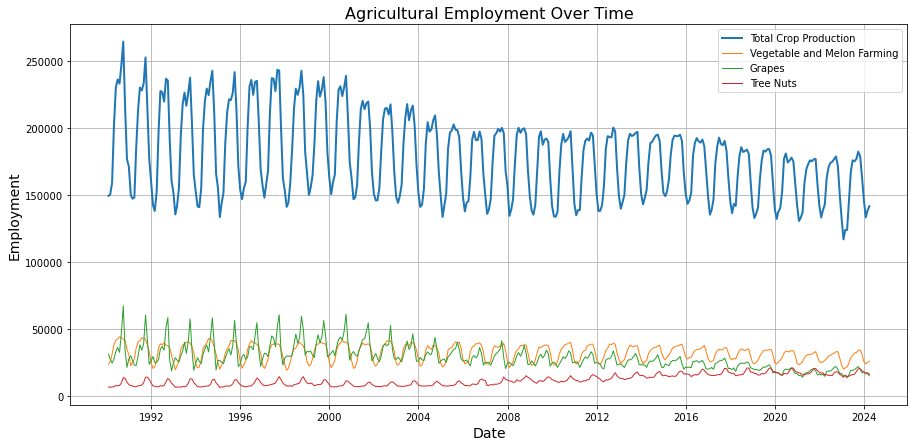

In [4]:
plt.figure(figsize=(15, 7))
plt.plot(df.index, df['TOTAL CROP PRODUCTION   '], label='Total Crop Production', linewidth=2)
plt.plot(df.index, df['VEGETABLE AND MELON FARMING'], label='Vegetable and Melon Farming', linewidth=1)
plt.plot(df.index, df['GRAPES'], label='Grapes', linewidth=1)
plt.plot(df.index, df['TREE NUTS'], label='Tree Nuts', linewidth=1)
plt.title('Agricultural Employment Over Time', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Employment', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

---

## 3. Forecasting and Plotting

We will forecast employment until 2050 using the three models for each category and plot the results in a composite figure.

Processing TOTAL CROP PRODUCTION   ...


15:38:26 - cmdstanpy - INFO - Chain [1] start processing
15:38:26 - cmdstanpy - INFO - Chain [1] done processing


Processing VEGETABLE AND MELON FARMING...


15:38:28 - cmdstanpy - INFO - Chain [1] start processing
15:38:28 - cmdstanpy - INFO - Chain [1] done processing


Processing GRAPES...


15:38:29 - cmdstanpy - INFO - Chain [1] start processing
15:38:29 - cmdstanpy - INFO - Chain [1] done processing


Processing TREE NUTS...


15:38:31 - cmdstanpy - INFO - Chain [1] start processing
15:38:31 - cmdstanpy - INFO - Chain [1] done processing


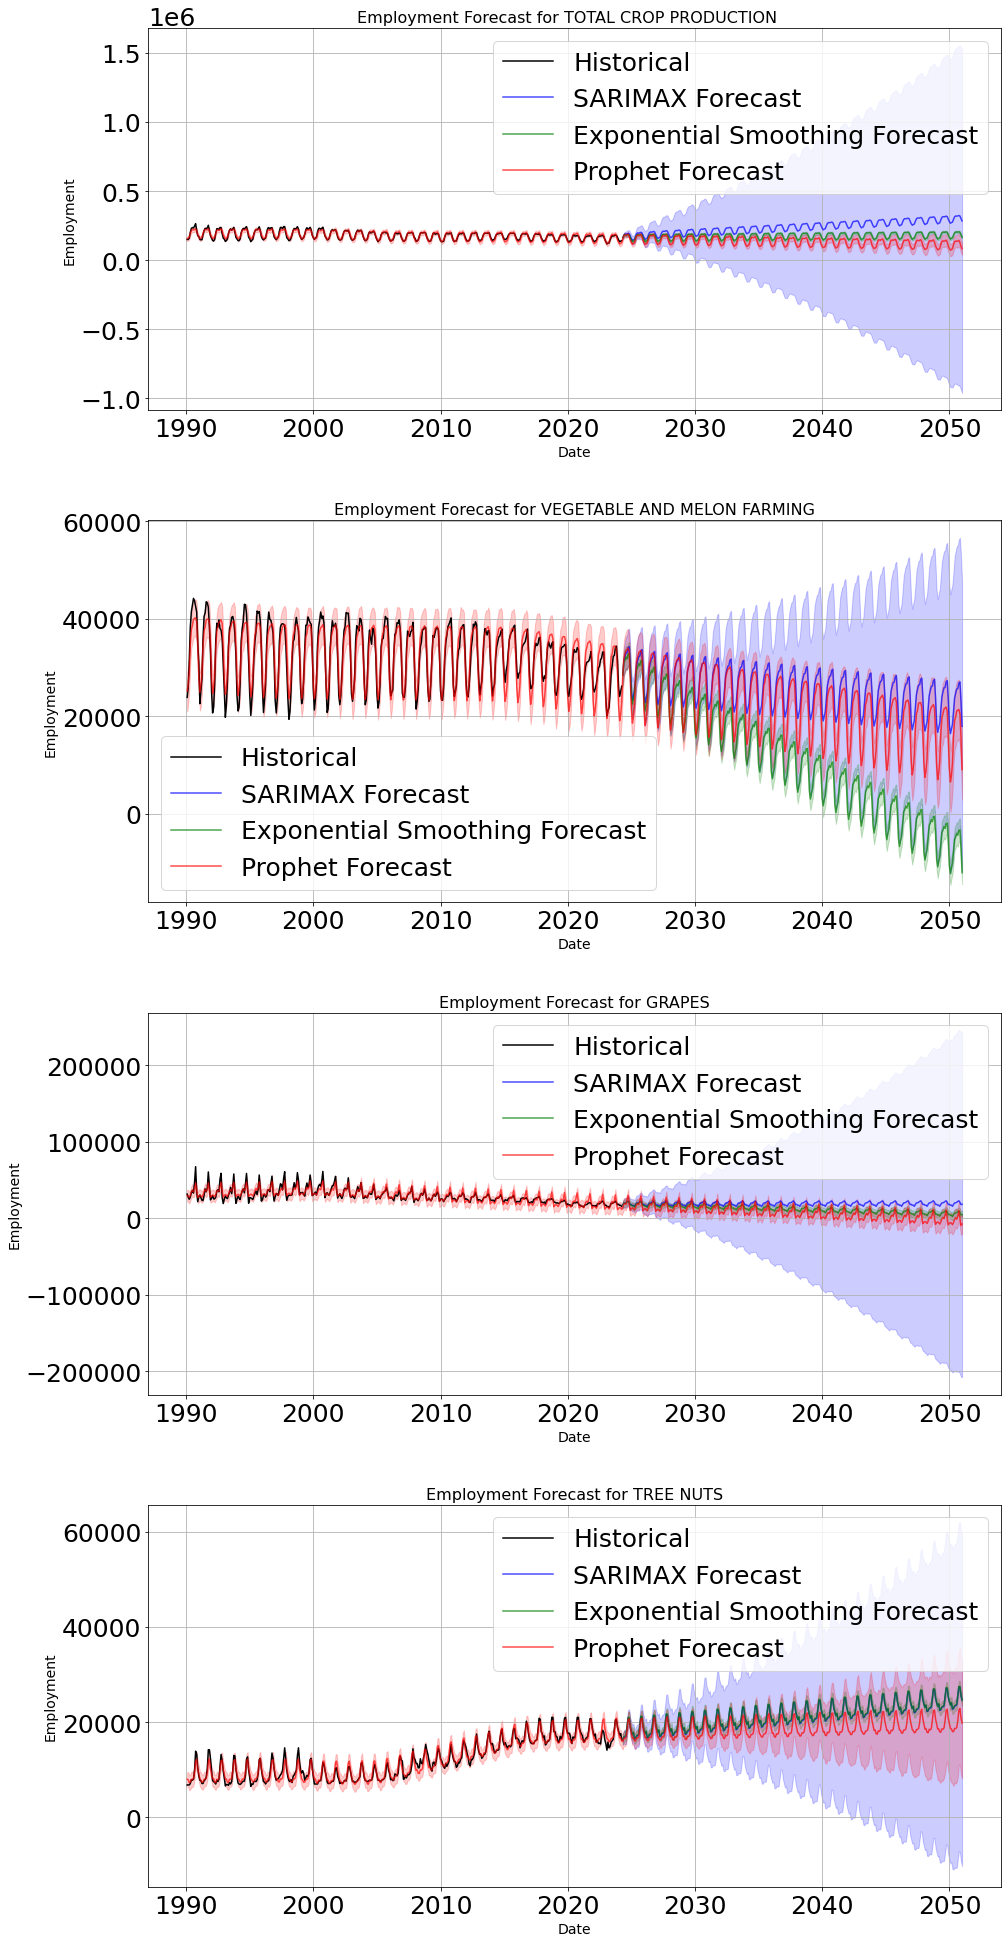

In [11]:
# Set global font sizes
plt.rcParams.update({
    'font.size': 40,         # Base font size
    'axes.titlesize': 40,    # Font size for titles
    'axes.labelsize': 40,    # Font size for axis labels
    'xtick.labelsize': 25,   # Font size for x-axis tick labels
    'ytick.labelsize': 25,   # Font size for y-axis tick labels
    'legend.fontsize': 25,   # Font size for legend
    'figure.titlesize': 40   # Font size for the figure title
})

# List of columns to forecast
columns = df.columns

# Initialize a list to store all results
all_results = []

# Create a composite figure with subplots (4 rows, 1 column)
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(15, 28))

# Loop over each category in the DataFrame
for i, col in enumerate(columns):
    print(f"Processing {col}...")
    series = df[col]

    # Prepare data for Prophet
    prophet_df = series.reset_index()
    prophet_df.columns = ['ds', 'y']

    # Ensure 'ds' column is datetime
    prophet_df['ds'] = pd.to_datetime(prophet_df['ds'])

    # Create future dates until 2050-12-31
    last_date = series.index[-1]
    future_dates = pd.date_range(start=last_date + MonthEnd(1), end='2050-12-31', freq='M')
    n_periods = len(future_dates)

    # -------------------- SARIMAX Model -------------------- #
    # Fit SARIMAX model
    sarimax_order = (1, 1, 1)
    seasonal_order = (1, 1, 1, 12)
    sarimax_model = SARIMAX(series, order=sarimax_order, seasonal_order=seasonal_order)
    sarimax_results = sarimax_model.fit(disp=False)

    # Forecast using SARIMAX
    sarimax_forecast = sarimax_results.get_forecast(steps=n_periods)
    sarimax_pred = sarimax_forecast.predicted_mean
    sarimax_conf_int = sarimax_forecast.conf_int()

    # Assign future dates as index
    sarimax_pred.index = future_dates
    sarimax_conf_int.index = future_dates

    # ---------------- Exponential Smoothing Model ---------------- #
    # Fit Exponential Smoothing model
    exp_model = ExponentialSmoothing(series, trend='add', seasonal='add', seasonal_periods=12)
    exp_results = exp_model.fit()

    # Forecast using Exponential Smoothing
    exp_pred = exp_results.forecast(steps=n_periods)

    # Manually compute confidence intervals for Exponential Smoothing
    residuals = exp_results.resid
    sigma = np.std(residuals)
    z = 1.96  # For 95% confidence interval
    exp_conf_int_lower = exp_pred - z * sigma
    exp_conf_int_upper = exp_pred + z * sigma

    # Combine into a DataFrame
    exp_conf_int = pd.DataFrame({'lower y': exp_conf_int_lower, 'upper y': exp_conf_int_upper}, index=future_dates)

    # -------------------- Prophet Model -------------------- #
    # Fit Prophet model
    prophet_model = Prophet(interval_width=0.95)
    prophet_model.fit(prophet_df)

    # Create future DataFrame for Prophet
    future_prophet = prophet_model.make_future_dataframe(periods=n_periods, freq='M')
    prophet_forecast = prophet_model.predict(future_prophet)

    # -------------------- Plotting -------------------- #
    ax = axes[i]

    # Plot historical data
    ax.plot(series.index, series, label='Historical', color='black', alpha=1)

    # Plot SARIMAX forecast
    ax.plot(sarimax_pred.index, sarimax_pred, label='SARIMAX Forecast', color='blue', alpha=0.7)
    ax.fill_between(sarimax_pred.index, sarimax_conf_int.iloc[:, 0], sarimax_conf_int.iloc[:, 1],
                    color='blue', alpha=0.2)

    # Plot Exponential Smoothing forecast
    ax.plot(exp_pred.index, exp_pred, label='Exponential Smoothing Forecast', color='green', alpha=0.7)
    ax.fill_between(exp_pred.index, exp_conf_int['lower y'], exp_conf_int['upper y'],
                    color='green', alpha=0.2)

    # Plot Prophet forecast
    ax.plot(prophet_forecast['ds'], prophet_forecast['yhat'], label='Prophet Forecast', color='red', alpha=0.7)
    ax.fill_between(prophet_forecast['ds'], prophet_forecast['yhat_lower'],
                    prophet_forecast['yhat_upper'], color='red', alpha=0.2)

    # Customize the plot
    ax.set_title(f'Employment Forecast for {col}', fontsize=16)
    ax.set_xlabel('Date', fontsize=14)
    ax.set_ylabel('Employment', fontsize=14)
    ax.legend()
    ax.grid(True)

    # -------------------- Extract Predictions -------------------- #
    # Define the dates for which we need the predictions
    dates_to_extract = ['2030-12-31', '2050-12-31']

    # Initialize a dictionary to store the results
    results = {'Category': col, '2023 Actual': actual_2023[col]}

    # -------------------- Extract SARIMAX Predictions -------------------- #
    sarimax_pred_2030 = sarimax_pred[dates_to_extract[0]]
    sarimax_pred_2050 = sarimax_pred[dates_to_extract[1]]
    sarimax_conf_2030 = sarimax_conf_int.loc[dates_to_extract[0]]
    sarimax_conf_2050 = sarimax_conf_int.loc[dates_to_extract[1]]

    # Store SARIMAX results
    results.update({
        'SARIMAX 2030 Forecast': sarimax_pred_2030,
        'SARIMAX 2030 Lower CI': sarimax_conf_2030.iloc[0],
        'SARIMAX 2030 Upper CI': sarimax_conf_2030.iloc[1],
        'SARIMAX 2050 Forecast': sarimax_pred_2050,
        'SARIMAX 2050 Lower CI': sarimax_conf_2050.iloc[0],
        'SARIMAX 2050 Upper CI': sarimax_conf_2050.iloc[1],
    })

    # -------------------- Extract Exponential Smoothing Predictions -------------------- #
    exp_pred_2030 = exp_pred[dates_to_extract[0]]
    exp_pred_2050 = exp_pred[dates_to_extract[1]]
    exp_conf_2030 = exp_conf_int.loc[dates_to_extract[0]]
    exp_conf_2050 = exp_conf_int.loc[dates_to_extract[1]]

    # Store Exponential Smoothing results
    results.update({
        'ExpSmooth 2030 Forecast': exp_pred_2030,
        'ExpSmooth 2030 Lower CI': exp_conf_2030['lower y'],
        'ExpSmooth 2030 Upper CI': exp_conf_2030['upper y'],
        'ExpSmooth 2050 Forecast': exp_pred_2050,
        'ExpSmooth 2050 Lower CI': exp_conf_2050['lower y'],
        'ExpSmooth 2050 Upper CI': exp_conf_2050['upper y'],
    })

    # -------------------- Extract Prophet Predictions -------------------- #
    # Prophet's forecast DataFrame is indexed by 'ds', so we'll match the dates
    prophet_forecast.set_index('ds', inplace=True)
    prophet_pred_2030 = prophet_forecast.loc[dates_to_extract[0], 'yhat']
    prophet_pred_2050 = prophet_forecast.loc[dates_to_extract[1], 'yhat']
    prophet_conf_2030_lower = prophet_forecast.loc[dates_to_extract[0], 'yhat_lower']
    prophet_conf_2030_upper = prophet_forecast.loc[dates_to_extract[0], 'yhat_upper']
    prophet_conf_2050_lower = prophet_forecast.loc[dates_to_extract[1], 'yhat_lower']
    prophet_conf_2050_upper = prophet_forecast.loc[dates_to_extract[1], 'yhat_upper']

    # Store Prophet results
    results.update({
        'Prophet 2030 Forecast': prophet_pred_2030,
        'Prophet 2030 Lower CI': prophet_conf_2030_lower,
        'Prophet 2030 Upper CI': prophet_conf_2030_upper,
        'Prophet 2050 Forecast': prophet_pred_2050,
        'Prophet 2050 Lower CI': prophet_conf_2050_lower,
        'Prophet 2050 Upper CI': prophet_conf_2050_upper,
    })

    # Append the results to a list for later use
    all_results.append(results)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

In [6]:
# Create the comparison DataFrame
comparison_df = pd.DataFrame(all_results)
comparison_df = comparison_df.set_index('Category')

# Display the comparison table
print("\nComparison of Predictions with Actual 2023 Values:\n")
print(comparison_df)


Comparison of Predictions with Actual 2023 Values:

                             2023 Actual  SARIMAX 2030 Forecast  \
Category                                                          
TOTAL CROP PRODUCTION           146400.0          188641.057674   
VEGETABLE AND MELON FARMING      25800.0           23151.342560   
GRAPES                           18100.0           17897.879707   
TREE NUTS                        18100.0           19601.792366   

                             SARIMAX 2030 Lower CI  SARIMAX 2030 Upper CI  \
Category                                                                    
TOTAL CROP PRODUCTION                -36545.752589          413827.867938   
VEGETABLE AND MELON FARMING           14779.185115           31523.500006   
GRAPES                               -21629.251064           57425.010478   
TREE NUTS                             12393.007682           26810.577049   

                             SARIMAX 2050 Forecast  SARIMAX 2050 Lower CI  \
Cate

In [7]:
comparison_df.to_csv('employment_forecast_comparison.csv')

---

**Explanation:**

- **Data Preparation:**
  - We read the data, transpose it, and clean it to ensure it's in the correct format for time series analysis.
  - The index is converted to datetime objects, and data is converted to numeric after removing commas.

- **Forecasting Loop:**
  - We iterate over each category (column) in the DataFrame.
  - For each category, we prepare the data for each model and forecast future values until 2050.
  - **SARIMAX Model:**
    - We specify the order and seasonal order parameters.
    - Fit the model and forecast future values with confidence intervals.
  - **Exponential Smoothing Model:**
    - Fit the Holt-Winters model with additive trend and seasonality.
    - Forecast future values.
    - Manually calculate confidence intervals using the residuals.
  - **Prophet Model:**
    - Prepare the data in the required format with 'ds' and 'y' columns.
    - Fit the model and predict future values with confidence intervals.

- **Plotting:**
  - We create a composite figure with four subplots, one for each category.
  - For each subplot, we plot the historical data and forecasts from all three models with their confidence intervals.
  - Transparency is adjusted using the `alpha` parameter to make overlapping lines visible.

---

## Assumptions and Comments

- **Data Assumptions:**
  - The time series data is monthly and spans a sufficient time period to capture trends and seasonality.
  - Missing values are handled appropriately, or there are none.

- **Model Assumptions:**
  - Each model's assumptions (listed above) hold true for the data.
  - The parameters used are basic and may need tuning for better accuracy.

- **General Comments:**
  - Forecasts are based on historical data patterns and assume these patterns continue into the future.
  - External factors not present in the historical data can affect future employment trends.
  - It's recommended to evaluate the models' performance using appropriate metrics and possibly incorporate additional variables for improved forecasts.

---